# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

I'll start with the data from the BRFSS again.

In [2]:
df = brfss.ReadBrfss(nrows=None)

Here are the mean and standard deviation of female height in cm.

In [3]:
female = df[df.sex==2]
female_heights = female.htm3.dropna()
mean, std = female_heights.mean(), female_heights.std()
mean, std

(163.22347500412215, 7.2691562866422323)

`NormalPdf` returns a Pdf object that represents the normal distribution with the given parameters.

`Density` returns a probability density, which doesn't mean much by itself.

In [4]:
pdf = thinkstats2.NormalPdf(mean, std)
pdf.Density(mean + std)

0.033287319047437085

`thinkplot` provides `Pdf`, which plots the probability density with a smooth curve.

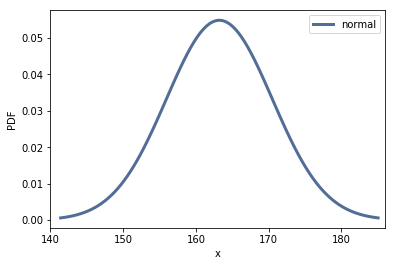

In [5]:
thinkplot.Pdf(pdf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

`Pdf` provides `MakePmf`, which returns a `Pmf` object that approximates the `Pdf`. 

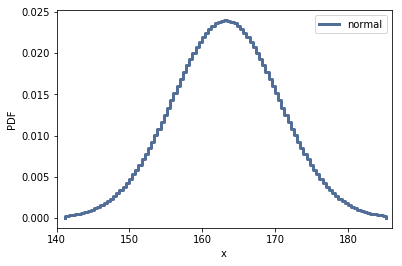

In [6]:
pmf = pdf.MakePmf()
thinkplot.Pmf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

If you have a `Pmf`, you can also plot it using `Pdf`, if you have reason to think it should be represented as a smooth curve.

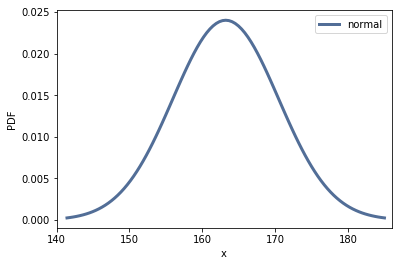

In [7]:
thinkplot.Pdf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

Using a sample from the actual distribution, we can estimate the PDF using Kernel Density Estimation (KDE).

If you run this a few times, you'll see how much variation there is in the estimate.

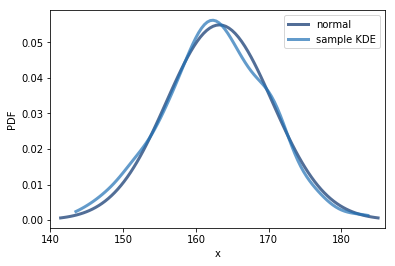

In [8]:
thinkplot.Pdf(pdf, label='normal')

sample = np.random.normal(mean, std, 500)
sample_pdf = thinkstats2.EstimatedPdf(sample, label='sample')
thinkplot.Pdf(sample_pdf, label='sample KDE')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

## Moments

Raw moments are just sums of powers.

In [9]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

The first raw moment is the mean.  The other raw moments don't mean much.

In [10]:
RawMoment(female_heights, 1), RawMoment(female_heights, 2), RawMoment(female_heights, 3)

(163.22347500412215, 26694.74321809659, 4374411.46250422)

In [11]:
def Mean(xs):
    return RawMoment(xs, 1)

Mean(female_heights)

163.22347500412215

The central moments are powers of distances from the mean.

In [12]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

The first central moment is approximately 0.  The second central moment is the variance.

In [13]:
CentralMoment(female_heights, 1), CentralMoment(female_heights, 2), CentralMoment(female_heights, 3)

(-9.903557940122168e-14, 52.84042567529328, -46.88569506887073)

In [14]:
def Var(xs):
    return CentralMoment(xs, 2)

Var(female_heights)

52.84042567529328

The standardized moments are ratios of central moments, with powers chosen to make the dimensions cancel.

In [15]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

The third standardized moment is skewness.

In [16]:
StandardizedMoment(female_heights, 1), StandardizedMoment(female_heights, 2), StandardizedMoment(female_heights, 3)

(-1.3624108479155668e-14, 1.0, -0.1220649274510512)

In [17]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

Skewness(female_heights)

-0.1220649274510512

Normally a negative skewness indicates that the distribution has a longer tail on the left.  In that case, the mean is usually less than the median.

In [18]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

But in this case the mean is greater than the median, which indicates skew to the right.

In [19]:
Mean(female_heights), Median(female_heights)

(163.22347500412215, 163.0)

Because the skewness is based on the third moment, it is not robust; that is, it depends strongly on a few outliers.  Pearson's median skewness is more robust.

In [20]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

Pearson's skewness is positive, indicating that the distribution of female heights is slightly skewed to the right.

In [21]:
PearsonMedianSkewness(female_heights)

0.092228905519051593

## Birth weights

Let's look at the distribution of birth weights again.

In [22]:
import first

live, firsts, others = first.MakeFrames()

Based on KDE, it looks like the distribution is skewed to the left.

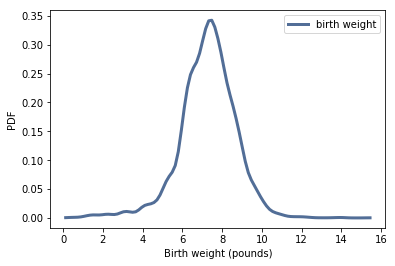

In [23]:
birth_weights = live.totalwgt_lb.dropna()
pdf = thinkstats2.EstimatedPdf(birth_weights)
thinkplot.Pdf(pdf, label='birth weight')
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='PDF')

The mean is less than the median, which is consistent with left skew.

In [24]:
Mean(birth_weights), Median(birth_weights)

(7.265628457623368, 7.375)

And both ways of computing skew are negative, which is consistent with left skew.

In [25]:
Skewness(birth_weights), PearsonMedianSkewness(birth_weights)

(-0.58950626875779888, -0.23300028954731833)

## Adult weights

Now let's look at adult weights from the BRFSS.  The distribution looks skewed to the right.

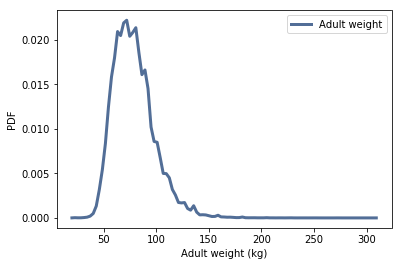

In [26]:
adult_weights = df.wtkg2.dropna()
pdf = thinkstats2.EstimatedPdf(adult_weights)
thinkplot.Pdf(pdf, label='Adult weight')
thinkplot.Config(xlabel='Adult weight (kg)', ylabel='PDF')

The mean is greater than the median, which is consistent with skew to the right.

In [27]:
Mean(adult_weights), Median(adult_weights)

(78.99245299687198, 77.269999999999996)

And both ways of computing skewness are positive.

In [28]:
Skewness(adult_weights), PearsonMedianSkewness(adult_weights)

(1.054840012109306, 0.26436733816180391)

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [29]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, row.freq)
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [30]:
import hinc
income_df = hinc.ReadData()

In [31]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

/Users/itiut/src/github.com/AllenDowney/ThinkStats2/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


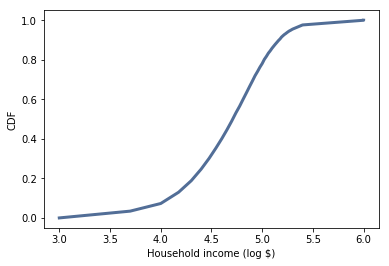

In [32]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [33]:
sample = np.power(10, log_sample)

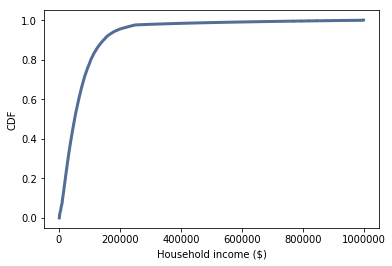

In [34]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [38]:
# Solution goes here
Median(sample), Mean(sample)

(51226.454478940461, 74278.707531187334)

In [39]:
# Solution goes here
Skewness(sample), PearsonMedianSkewness(sample)

(4.9499202444295829, 0.7361258019141782)

In [37]:
# Solution goes here
sample.cdf()

0.7361258019141782

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.